
# Number Partition Problem


## Introduction

In the Number Partitioning Problem [[1](#PartitionWiki)] we need to find how to partition a set of integers into two subsets of equal sums. In case such a partition does not exist, we can ask for a partition where the difference between the sums is minimal.

## Mathematical formulation

Given a set of numbers $S=\{s_1,s_2,...,s_n\}$, a partition is defined as $P_1,P_2 \subset \{1,...,n\}$, with $P_1\cup P_2=\{1,...,n\}$ and $P_1\cap P_2=\emptyset$. In the Number Partitioning Problem we need to determine a partition such that $|\sum_{j\in P_1}s_j-\sum_{j\in P_2}s_j|$ is minimal. A partition can be represented by a binary vector $x$ of size $n$, where we assign 0 or 1 for being in $P_1$ or $P_2$, respectively. The quantity we ask to minimize is $|\vec{x}\cdot \vec{s}-(1-\vec{x})\cdot\vec{s}|=|(2\vec{x}-1)\cdot\vec{s}|$. In practice we will minimize the square of this expression.

## Solving with the Classiq platform

We go through the steps of solving the problem with the Classiq platform, using QAOA algorithm [[2](#QAOA)]. The solution is based on defining a pyomo model for the optimization problem we would like to solve.

In [1]:
import networkx as nx
import numpy as np
import pyomo.core as pyo
from matplotlib import pyplot as plt

## Building the Pyomo model from a graph input

We proceed by defining the Pyomo model that will be used on the Classiq platform, using the mathematical formulation defined above:

In [2]:
# we define a matrix which gets a set of integers s and returns a pyomo model for the partitioning problem


def partite(s) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel()
    SetSize = len(s)  # the set size
    model.x = pyo.Var(
        range(SetSize), domain=pyo.Binary
    )  # our variable is a binary vector

    # we define a cost function
    model.cost = pyo.Objective(
        expr=sum(((2 * model.x[i] - 1) * s[i]) for i in range(SetSize)) ** 2,
        sense=pyo.minimize,
    )

    return model

In [3]:
Myset = np.random.randint(1, 12, 10)
mylist = [int(x) for x in Myset]
print("This is my list: ", mylist)
set_partition_model = partite(mylist)

This is my list:  [4, 5, 2, 10, 6, 11, 9, 4, 9, 1]


In [4]:
set_partition_model.pprint()

1 Var Declarations
    x : Size=10, Index={0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary
          7 :     0 :  None :     1 : False :  True : Binary
          8 :     0 :  None :     1 : False :  True : Binary
          9 :     0 :  None :     1 : False :  True : Binary

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : ((2*x[0] - 1)*4 + (2*x[1] - 1)*5 + (2*x[2] - 1)*2 + (2*x[3] - 1)*10 + (2*x[4] - 1)*6 + (2*x[5] - 1)*11 + (

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the `CombinatorialProblem` python class. Under the hood it tranlates the Pyomo model to a quantum model of the QAOA algorithm, with cost hamiltonian translated from the Pyomo model. We can choose the number of layers for the QAOA ansatz using the argument `num_layers`, and the `penalty_factor`, which will be the coefficient of the constraints term in the cost hamiltonian.

In [5]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(
    pyo_model=set_partition_model, num_layers=3, penalty_factor=10
)

qmod = combi.get_model()

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [6]:
qprog = combi.get_qprog()
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/38wAskQKdsHfkzDGJFSuT3lBDHt


https://platform.classiq.io/circuit/38wAskQKdsHfkzDGJFSuT3lBDHt?login=True&version=15

We also set the quantum backend we want to execute on:

In [7]:
from classiq.execution import *

execution_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator"),
)

We now solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [8]:
optimized_params = combi.optimize(execution_preferences, maxiter=80, quantile=0.7)

We can check the convergence of the run:

Text(0.5, 1.0, 'Cost convergence')

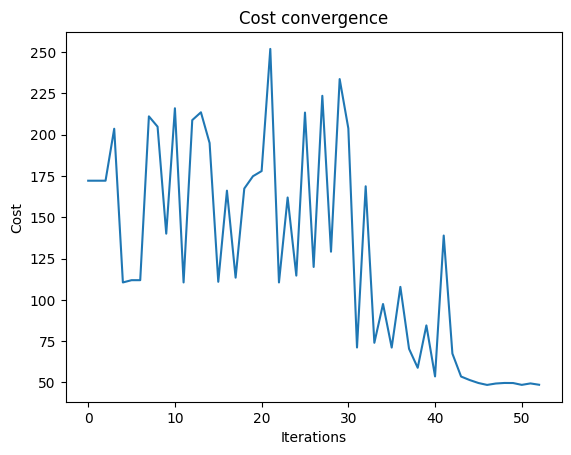

In [9]:
plt.plot(combi.cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

## Optimization Results

We can also examine the statistics of the algorithm. In order to get samples with the optimized parameters, we call the `sample` method:

In [10]:
optimization_result = combi.sample(optimized_params)
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
0,"{'x': [1, 0, 0, 1, 0, 1, 0, 1, 0, 1]}",0.018066,1
88,"{'x': [1, 1, 0, 0, 0, 1, 1, 0, 0, 1]}",0.002441,1
263,"{'x': [0, 0, 1, 1, 1, 1, 0, 0, 0, 1]}",0.000977,1
285,"{'x': [1, 1, 1, 1, 1, 0, 0, 1, 0, 0]}",0.000977,1
287,"{'x': [0, 1, 0, 1, 1, 0, 1, 0, 0, 1]}",0.000977,1


We will also want to compare the optimized results to uniformly sampled results:

In [11]:
uniform_result = combi.sample_uniform()

And compare the histograms:

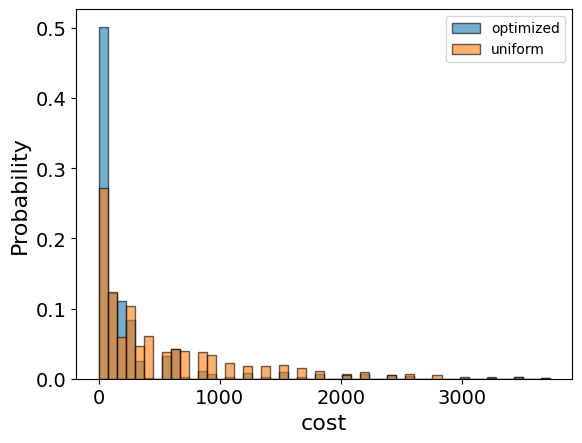

In [12]:
optimization_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=optimization_result["probability"],
    alpha=0.6,
    label="optimized",
)
uniform_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=uniform_result["probability"],
    alpha=0.6,
    label="uniform",
)
plt.legend()
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

Let us plot the best solution:

In [13]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]

In [14]:
p1 = [mylist[i] for i in range(len(mylist)) if best_solution["x"][i] == 0]
p2 = [mylist[i] for i in range(len(mylist)) if best_solution["x"][i] == 1]
print("P1=", p1, ", total sum: ", sum(p1))
print("P2=", p2, ", total sum: ", sum(p2))
print("difference= ", abs(sum(p1) - sum(p2)))

P1= [5, 2, 6, 9, 9] , total sum:  31
P2= [4, 10, 11, 4, 1] , total sum:  30
difference=  1


Lastly, we can compare to the classical solution of the problem:

In [15]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(set_partition_model)

set_partition_model.display()

Model unknown

  Variables:
    x : Size=10, Index={0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   1.0 :     1 : False : False : Binary
          1 :     0 :   1.0 :     1 : False : False : Binary
          2 :     0 :   1.0 :     1 : False : False : Binary
          3 :     0 :   1.0 :     1 : False : False : Binary
          4 :     0 :   1.0 :     1 : False : False : Binary
          5 :     0 :   0.0 :     1 : False : False : Binary
          6 :     0 :   0.0 :     1 : False : False : Binary
          7 :     0 :   1.0 :     1 : False : False : Binary
          8 :     0 :   0.0 :     1 : False : False : Binary
          9 :     0 :   0.0 :     1 : False : False : Binary

  Objectives:
    cost : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :   1.0

  Constraints:
    None


In [16]:
classical_solution = [pyo.value(set_partition_model.x[i]) for i in range(len(mylist))]

In [17]:
p1 = [mylist[i] for i in range(len(mylist)) if round(classical_solution[i]) == 0]
p2 = [mylist[i] for i in range(len(mylist)) if round(classical_solution[i]) == 1]
print("P1=", p1, ", total sum: ", sum(p1))
print("P2=", p2, ", total sum: ", sum(p2))
print("difference= ", abs(sum(p1) - sum(p2)))

P1= [11, 9, 9, 1] , total sum:  30
P2= [4, 5, 2, 10, 6, 4] , total sum:  31
difference=  1



## References

<a id='PartitionWiki'>[1]</a>: [Number Partitioning Problem (Wikipedia)](https://en.wikipedia.org/wiki/Partition_problem)

<a id='QAOA'>[2]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
